# RNN作业

本次作业要求实现词性标注任务，给定一个单词，通过RNN和LSTM模型输出单词的词性。

所有数据都在data文件夹中，每个文件的命名即其词性。

请注意，为了方便比较同学们结果，**读取数据并划分数据集这部分代码不可更改**。

后续字符的编码，模型的搭建，模型的训练会给出一个参考baseline模版，同学们可以选择在此baseline模版下构建模型，
也可以选择**任意增删改**这部分代码构建自己的模型并优化.（全部删除这部分代码，自己重新写也可以)

**同学们还可以考虑用CNN提取序列特征进行分类，此部分实现并在模型评价进行对比，会得到3分的附加分。**

**如果觉得自己此部分特别优秀，可以单独写一个readme文件对自己的工作进行描述，会得到1-3分附加分。**

最后模型的评价部分要求分别输出RNN模型和LSTM模型在训练集和测试集上的正确率。**注意最终提交的版本必须已经正确显示这四个值,
如果需要助教重新跑模型得到结果，会扣除3分。**



In [1]:
#import packages
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output

## 读取数据并划分数据集（勿更改代码）

In [2]:
def findFiles(path): 
    return glob.glob(path)
tags = []
X = []
y = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

for filename in findFiles('data/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    if language not in tags:
        tags.append(language)
    lines = readLines(filename)
    for line in lines:
        X.append(line)
        y.append(language)

n_tags = len(tags)
#tags:['CD','IN',...]; n_tags:14

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =10, stratify = y)
# X:[higly,hardware,...]; Y:['RB','NN',...]
# train:text = 8509 : 2128

##  字符的编码

本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

In [3]:
# 统计字符
s = set()
for path in findFiles('data/*.txt'):
    f = open(path,"r")
    for word in f.readlines():
        for char in word:
            s.add(char)
    f.close()
all_letters = "" #"X38hl6dNITFrUK,-SQYZVsq1f.4gJPv:cABp\\0nWHEM&5\neaoyu'72@DOCL9mzkw%bj/GixtR"
for c in s:
    all_letters+=str(c)

n_letters = len(all_letters) #73


In [4]:
#function to create name representation
def name_rep(name): #One Hot
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [5]:
#function to create lang representation
def nat_rep(lang): #tags to index
    return torch.tensor([tags.index(lang)], dtype = torch.long)

In [6]:
#create a dataloader
def dataloader(batch_size, X_, y_):
    to_ret = []
    for i in range(batch_size):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #get the data at the random index
        to_ret.append((name, lang, name_rep(name), nat_rep(lang)))

    return to_ret

## 模型的搭建

本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

模型需要分别构建rnn和lstm模型

In [7]:
# TODO

class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        
        #Defining some parameters
        self.hidden_size = hidden_size
        
        #Defining the layers
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
        #Fully connected layer
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden


    def init_hidden(self):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        return torch.zeros(1, self.hidden_size)

In [8]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        
        #Defining some parameters
        self.hidden_size=hidden_size
        
        #Defining the layers
        self.lstm=nn.LSTM(input_size,hidden_size)
        self.out=nn.Linear(hidden_size,output_size)
        
        #Fully connected layer
        self.softmax = nn.LogSoftmax(dim = 1)


    def forward(self, input_, hidden):
        output, hidden = self.lstm(input_.view(len(input_), 1, -1), hidden)
        output = self.out(output.view(len(input_), -1))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

## 模型的训练


本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

In [9]:
#function to train the data
def train_step(net, opt, criterion, batch_size):
    
    opt.zero_grad()
    total_loss = 0
    data_ = dataloader(batch_size, X_train, y_train)
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/batch_size

In [10]:
def train(net, lr = 0.01, steps = 100, batch_size = 10, momentum = 0.9, freq = 5):

    criterion = nn.NLLLoss()  # TODO
    opt = torch.optim.Adam(net.parameters(), lr=lr)       # TODO
    loss_arr = np.zeros(steps)

    #iterate through all the batches
    for i in range(steps):
        loss_arr[i] = train_step(net, opt, criterion, batch_size)
        if (i+1)%freq==0: 
            print("Iteration number:", i + 1,'Loss:', round(loss_arr[i],4))

    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    print("\n\n")


Iteration number: 5 Loss: 2.5783
Iteration number: 10 Loss: 2.4614
Iteration number: 15 Loss: 2.3371
Iteration number: 20 Loss: 2.1467
Iteration number: 25 Loss: 2.1359
Iteration number: 30 Loss: 2.1108
Iteration number: 35 Loss: 2.0154
Iteration number: 40 Loss: 2.0481
Iteration number: 45 Loss: 2.0333
Iteration number: 50 Loss: 1.9477
Iteration number: 55 Loss: 1.9847
Iteration number: 60 Loss: 1.8304
Iteration number: 65 Loss: 1.8454
Iteration number: 70 Loss: 1.8308
Iteration number: 75 Loss: 1.7228
Iteration number: 80 Loss: 1.7474
Iteration number: 85 Loss: 1.8172
Iteration number: 90 Loss: 1.5276
Iteration number: 95 Loss: 1.6126
Iteration number: 100 Loss: 1.6138
Iteration number: 105 Loss: 1.6097
Iteration number: 110 Loss: 1.4938
Iteration number: 115 Loss: 1.4347
Iteration number: 120 Loss: 1.5972
Iteration number: 125 Loss: 1.6868
Iteration number: 130 Loss: 1.5216
Iteration number: 135 Loss: 1.4253
Iteration number: 140 Loss: 1.5135
Iteration number: 145 Loss: 1.4975
Itera

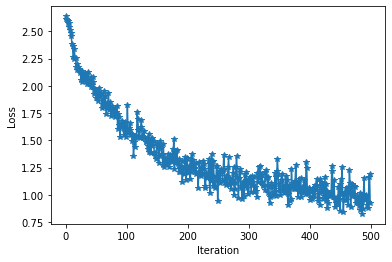

In [18]:
# rnn训练
n_hidden = 128
rnn_net = RNN_net(n_letters, n_hidden, n_tags)
train(rnn_net, lr = 0.0005, steps = 500, batch_size = 256)

Iteration number: 5 Loss: 2.6188
Iteration number: 10 Loss: 2.5585
Iteration number: 15 Loss: 2.4539
Iteration number: 20 Loss: 2.2537
Iteration number: 25 Loss: 2.281
Iteration number: 30 Loss: 2.2433
Iteration number: 35 Loss: 2.1683
Iteration number: 40 Loss: 2.1623
Iteration number: 45 Loss: 2.1146
Iteration number: 50 Loss: 2.1186
Iteration number: 55 Loss: 2.1457
Iteration number: 60 Loss: 1.9622
Iteration number: 65 Loss: 2.0479
Iteration number: 70 Loss: 1.9698
Iteration number: 75 Loss: 1.9357
Iteration number: 80 Loss: 1.7925
Iteration number: 85 Loss: 1.8227
Iteration number: 90 Loss: 1.68
Iteration number: 95 Loss: 1.65
Iteration number: 100 Loss: 1.5949
Iteration number: 105 Loss: 1.541
Iteration number: 110 Loss: 1.5124
Iteration number: 115 Loss: 1.6635
Iteration number: 120 Loss: 1.3885
Iteration number: 125 Loss: 1.4447
Iteration number: 130 Loss: 1.4608
Iteration number: 135 Loss: 1.4719
Iteration number: 140 Loss: 1.3196
Iteration number: 145 Loss: 1.3116
Iteration n

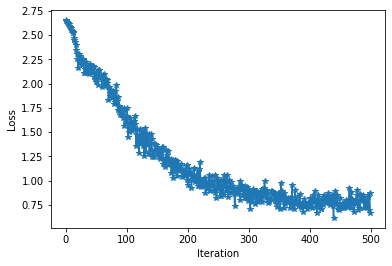

In [20]:
# lstm训练
n_hidden = 128
lstm_net = LSTM_net(n_letters, n_hidden, n_tags)
train(lstm_net, lr = 0.001, steps = 500, batch_size = 256)

## 模型效果评价


分别输出RNN模型和LSTM模型在训练集和测试集上的正确率。**注意最终提交的版本必须已经正确显示这四个值,
如果需要助教重新跑模型得到结果，会扣除3分。**


In [13]:
def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [14]:
#create a function to evaluate model

def eval_test(net):
     correct = 0
     for i in range(len(X_test)):
        name,lang = X_test[i],y_test[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_test)

     return accuracy

In [15]:
#create a function to evaluate model

def eval_train(net):
     correct = 0
     for i in range(len(X_train)):
        name,lang = X_train[i],y_train[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_train)

     return accuracy

In [19]:
print("rnn结果")
print("train set accuracy:"+str(round(eval_train(rnn_net),4)))
print("test set accuracy:"+str(round(eval_test(rnn_net),4)))

rnn结果
train set accuracy:0.7128
test set accuracy:0.6913


In [21]:
print("LSTM结果")
print("train set accuracy:"+str(round(eval_train(lstm_net),4)))
print("test set accuracy:"+str(round(eval_test(lstm_net),4)))

LSTM结果
train set accuracy:0.7547
test set accuracy:0.7472
